In [1]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from datasets import load_dataset
from torchvision import transforms
import torch
import torch.nn.functional as F
from PIL import Image
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from accelerate import Accelerator, notebook_launcher
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import math
import os
import glob

C:\Users\csvol\anaconda3\envs\torch_cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Before running with M1 chip:
conda env config vars set PYTORCH_ENABLE_MPS_FALLBACK=1

In [2]:
torch.cuda.is_available()

True

# Set Configs

In [3]:
@dataclass
class TrainingConfig:
    # image_size = 128  # the generated image resolution
    image_size = 64
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 1000
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 25
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    # mixed_precision = 'no'  # requires a GPU
    output_dir = 'model_230314'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

# Create the Dataset

In [4]:
DIR="images/"
dataset = load_dataset("imagefolder", data_dir=DIR)

Resolving data files: 100%|█████████████████████████████████████████████████████| 4199/4199 [00:00<00:00, 14681.82it/s]
Found cached dataset imagefolder (C:/Users/csvol/.cache/huggingface/datasets/imagefolder/default-7539e19d6dcce2de/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]


In [5]:
type(dataset['train'][0]['image'])

PIL.PngImagePlugin.PngImageFile

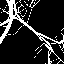

In [6]:
dataset['train'][0]['image'].getchannel(2)

In [7]:
dataset['train'][0]['image'].size

(64, 64)

# Plot a few example images

C:\Users\csvol\AppData\Local\Temp\ipykernel_3664\3112336546.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


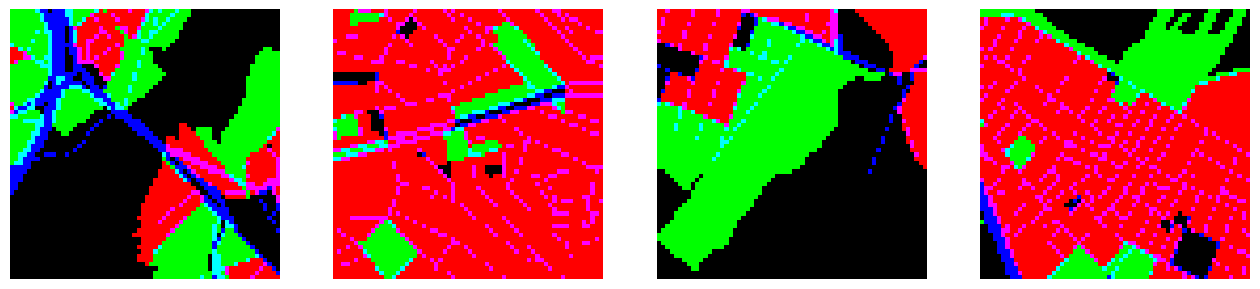

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset['train'][:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

# Apply Transforms

In [9]:
preprocess = transforms.Compose(
    [
        # transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [10]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset["train"].set_transform(transform)

In [11]:
dataset["train"][0]['images'].shape

torch.Size([3, 64, 64])

In [12]:
# plt.imshow(dataset["train"][0]['images'][0, :, :])

In [13]:
# type(dataset["train"][0]['images'])

# Plot transformed images

C:\Users\csvol\AppData\Local\Temp\ipykernel_3664\3663968338.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


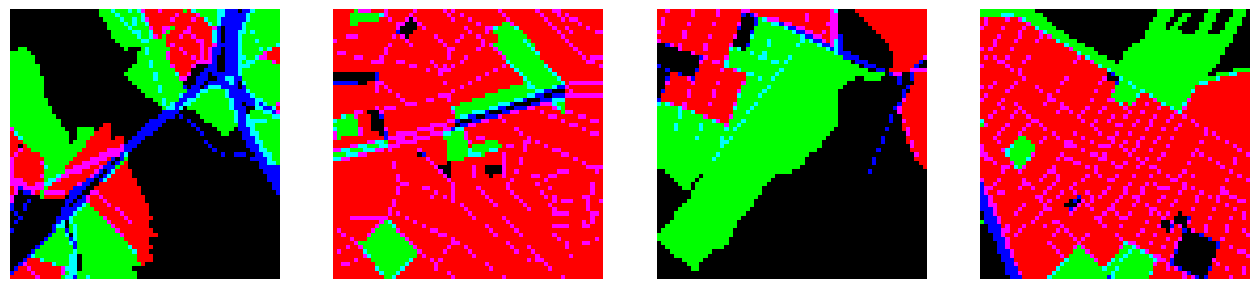

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

# Set up Dataloader

In [15]:
train_dataloader = torch.utils.data.DataLoader(dataset["train"], batch_size=config.train_batch_size, shuffle=True)

# Diffusion Model

In [16]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 
                         128, 256, 
                        256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
         "DownBlock2D", 
         "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
         "UpBlock2D", 
         "UpBlock2D", 
        "UpBlock2D"  
      ),
)

In [17]:
sample_image = dataset["train"][0]['images'].unsqueeze(0)

In [18]:
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 64, 64])


In [19]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 64, 64])


## Define the noise scheduler

In [20]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

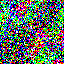

In [21]:
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([2])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [22]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

## Set up training

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

 And a cosine learning rate schedule:

In [24]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

# Model evaluation with DDPMPipeline

In [25]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

# Training Loop

In [26]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir) 

# Train Model

In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

C:\Users\csvol\anaconda3\envs\torch_cuda\lib\site-packages\accelerate\accelerator.py:353: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


Launching training on one GPU.


Epoch 0: 100%|████████████████████████████████████| 263/263 [01:01<00:00,  4.24it/s, loss=0.0685, lr=5.26e-5, step=262]

Epoch 2: 100%|█████████████████████████████████████| 263/263 [00:55<00:00,  4.70it/s, loss=0.0342, lr=0.0001, step=788]

Epoch 4: 100%|████████████████████████████████████| 263/263 [00:56<00:00,  4.69it/s, loss=0.0426, lr=0.0001, step=1314]

Epoch 6: 100%|████████████████████████████████████| 263/263 [00:56<00:00,  4.67it/s, loss=0.0566, lr=0.0001, step=1840]

Epoch 8: 100%|████████████████████████████████████| 263/263 [00:56<00:00,  4.64it/s, loss=0.0199, lr=0.0001, step=2366]

Epoch 10: 100%|████████████████████████████████████| 263/263 [00:55<00:00,  4.73it/s, loss=0.013, lr=0.0001, step=2892]

Epoch 12: 100%|███████████████████████████████████| 263/263 [00:54<00:00,  4.82it/s, loss=0.0131, lr=0.0001, step=3418]

Epoch 14: 100%|███████████████████████████████████| 263/263 [00:55<00:00,  4.78it/s, loss=0.0316, lr=0.0001, step=3944]

Epoch 16: 100%|█████████████████

Let's have a look at the final image grid produced by the trained diffusion model:

In [ ]:
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])